# Примена конволуционих неуронских мрежа у процесу преноса уметничког стила слике

In [26]:
import numpy as np
from PIL import Image

import tensorflow as tf

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

In [27]:
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [28]:
content_image_path = "tara.JPEG"
style_image_path = "waves.jpg"
output_image_path = "output.png"

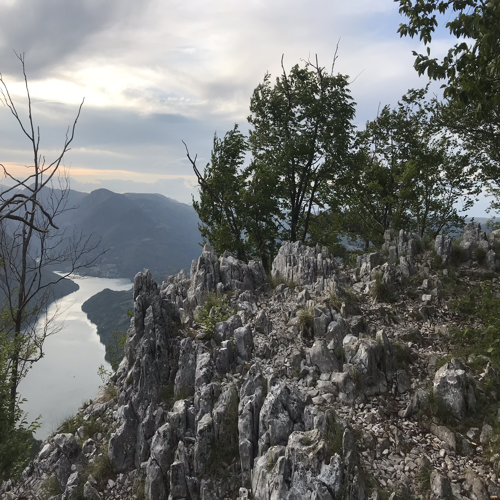

In [29]:
content_image = Image.open(content_image_path)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image

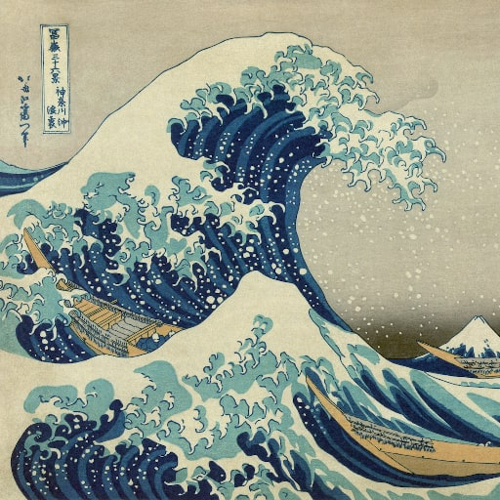

In [30]:
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image

In [31]:
content_image_array = np.asarray(content_image, dtype="float32")
content_image_array = np.expand_dims(content_image_array, axis=0)
print(content_image_array.shape)


style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
print(style_image_array.shape)

(1, 500, 500, 3)
(1, 500, 500, 3)


In [32]:
content_array = content_image_array
style_array = style_image_array

print(content_array.shape)
print(style_array.shape)

(1, 500, 500, 3)
(1, 500, 500, 3)


In [33]:
content_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
content_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
content_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
content_array = content_array[:, :, :, ::-1]

In [34]:
style_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_array = style_array[:, :, :, ::-1]

In [35]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [36]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features, combination_features)

In [37]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [38]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss

In [39]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

Iteration 0 completed with loss 60747124736
Iteration 1 completed with loss 29434034176
Iteration 2 completed with loss 21418029056
Iteration 3 completed with loss 18579554304
Iteration 4 completed with loss 17440382976
Iteration 5 completed with loss 16810919936
Iteration 6 completed with loss 16446427136
Iteration 7 completed with loss 16217625600
Iteration 8 completed with loss 16063083520
Iteration 9 completed with loss 15952817152


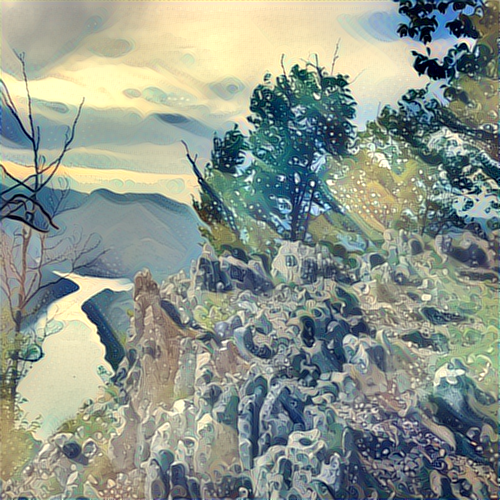

In [40]:
outputs = [loss]

#tf.compat.v1.disable_eager_execution()
outputs = outputs + backend.gradients(loss, combination_image)

def evaluate(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image